In [1]:
import matplotlib.pyplot as plt

In [2]:
import numpy as np

In [3]:
import respy

# Problem Statement

A heterogeneous 2D reservoir (L=3000 ft, W=3000 ft, H=20 ft) is saturated with oil at residual water saturation. The endpoint relative permeability and viscosity are constant and are 1.0 and 5 cp, respectively. Formation volume factor of oil is uniform throughout the reservoir. The total compressibility is 1E-5 psi.

The reservoir is discretized into $N_x=3$, $N_y=3$, $N_z=1$ nonuniform grids, ${\Delta}x=[750, 1000, 1250]$ ft and ${\Delta}y=[750, 1000, 1250]$ ft.

The permeability is anisotropic, $k_y=k_x\times0.5$, $k_z=k_x\times0.1$ and both x-direction permeability and porosity are heterogeneous as given below. 

$k_x=[50, 100, 200, 100, 150, 250, 150, 200, 300]$ mD

The depth is uniform, and the porosity distribution is given as following:

$\phi=[0.15, 0.18, 0.20, 0.17, 0.20, 0.22, 0.22, 0.25, 0.26]$

Create the arrays and solve the pressure field implicitly for three timesteps. The initial condition is $P=3000$ psia.

Assume no-flow conditions on all boundaries. There is a constant BHP vertical well in block #1 (index 0) ($P_{wf}=4000$ psia) and constant BHP horizontal well perforated in blocks #8 and #9 (index 7 and 8) ($P_{wf}$=2000 psia). The wellbore radius is 0.25 ft.

**Ref**: Balhoff, Reservoir Simulation, Chaptear 5, Example 5.4

# Single Phase Linear Solver

**1. Input Data**

Grid Properties:

In [4]:
xdelta = np.array([750,1000,1250])
ydelta = np.array([750,1000,1250])
zdelta = 20

Reservoir Rock Properties:

In [5]:
xperm = np.array([50,100,200,100,150,250,150,200,300])
yperm = xperm/2
zperm = xperm/10

In [6]:
poro = np.array([0.15,0.18,0.20,0.17,0.20,0.22,0.22,0.25,0.26])

Fluid Properties

In [7]:
visc = 5

**2. Gridding**

In [8]:
delta = respy.GridDelta(xdelta,ydelta,20)

In [9]:
delta.xdelta

array([ 750., 1000., 1250.])

In [10]:
delta.ydelta

array([ 750., 1000., 1250.])

In [11]:
delta.depths

array([1000.])

In [12]:
delta.dims

2

In [13]:
delta.grids.dims

2

In [14]:
delta.grids.volume

array([11250010.60135316, 15000014.13513754, 18750017.66892192,
       15000014.13513754, 20000018.84685005, 25000023.55856256,
       18750017.66892192, 25000023.55856256, 31250029.4482032 ])

In [15]:
delta.index

array([0, 1, 2, 3, 4, 5, 6, 7, 8])

In [16]:
delta.table

array([[0, 1, 0, 3],
       [0, 2, 1, 4],
       [1, 2, 2, 5],
       [3, 4, 0, 6],
       [3, 5, 1, 7],
       [4, 5, 2, 8],
       [6, 7, 3, 6],
       [6, 8, 4, 7],
       [7, 8, 5, 8]])

**3. Property Calculation**

In [17]:
rock = respy.RRock(xperm,yperm=yperm,zperm=zperm,poro=poro)

In [18]:
rock.xperm

array([ 50., 100., 200., 100., 150., 250., 150., 200., 300.])

In [19]:
rock.yperm

array([ 25.,  50., 100.,  50.,  75., 125.,  75., 100., 150.])

In [20]:
rock.poro

array([0.15, 0.18, 0.2 , 0.17, 0.2 , 0.22, 0.22, 0.25, 0.26])

In [21]:
oil = respy.Fluid(visc=visc)

In [22]:
oil.visc

array([5.])

**4. Configuration**

In [23]:
time = respy.Time((1,)*5)

In [24]:
time.total

np.float64(5.0)

In [25]:
time.steps

array([1., 1., 1., 1., 1.])

In [26]:
time.nums

5

In [27]:
for tcurr,tstep in time:
    print(tcurr,tstep)

0.0 86400.0
86400.0 86400.0
172800.0 86400.0
259200.0 86400.0
345600.0 86400.0


In [28]:
w1 = respy.Well((0,),axis='z',radius=0.25,skin=2,press=4000)
w2 = respy.Well((7,8),axis='x',radius=0.25,skin=0,press=2000)

In [29]:
w2.index

(7, 8)

**5. Simulation**

In [30]:
solver = respy.BaseSolver(delta.grids,rock,oil,tcomp=1e-5)

In [59]:
vec = solver.vector(5*24*60*60,wells=(w1,w2))
mat = solver.matrix(vec)

In [60]:
vec.X

array([1.51878975, 2.33659961, 3.57362293, 4.33939927, 6.32829061,
       6.90358975])

In [61]:
vec.Y

array([0.75939487, 1.78681147, 4.08276813, 1.03553846, 1.9597287 ,
       3.87446364])

In [62]:
vec.Z

array([], dtype=float64)

In [63]:
vec.A/1e-5

array([ 337500.0324 ,  540000.05184,  750000.072  ,  510000.04896,
        800000.0768 , 1100000.1056 ,  825000.0792 , 1250000.12   ,
       1625000.156  ])

In [65]:
mat.A.todense()/1e-5

matrix([[ 337500.0324 ,       0.     ,       0.     ,       0.     ,
               0.     ,       0.     ,       0.     ,       0.     ,
               0.     ],
        [      0.     ,  540000.05184,       0.     ,       0.     ,
               0.     ,       0.     ,       0.     ,       0.     ,
               0.     ],
        [      0.     ,       0.     ,  750000.072  ,       0.     ,
               0.     ,       0.     ,       0.     ,       0.     ,
               0.     ],
        [      0.     ,       0.     ,       0.     ,  510000.04896,
               0.     ,       0.     ,       0.     ,       0.     ,
               0.     ],
        [      0.     ,       0.     ,       0.     ,       0.     ,
          800000.0768 ,       0.     ,       0.     ,       0.     ,
               0.     ],
        [      0.     ,       0.     ,       0.     ,       0.     ,
               0.     , 1100000.1056 ,       0.     ,       0.     ,
               0.     ],
        [      0.     

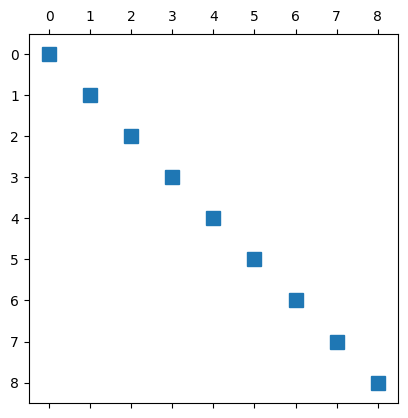

In [66]:
plt.spy(mat.A); plt.show()

In [67]:
mat.T.todense()

matrix([[ 2.27818462, -1.51878975,  0.        , -0.75939487,  0.        ,
          0.        ,  0.        ,  0.        ,  0.        ],
        [-1.51878975,  5.64220082, -2.33659961,  0.        , -1.78681147,
          0.        ,  0.        ,  0.        ,  0.        ],
        [ 0.        , -2.33659961,  6.41936774,  0.        ,  0.        ,
         -4.08276813,  0.        ,  0.        ,  0.        ],
        [-0.75939487,  0.        ,  0.        ,  5.36855627, -3.57362293,
          0.        , -1.03553846,  0.        ,  0.        ],
        [ 0.        , -1.78681147,  0.        , -3.57362293, 11.65956237,
         -4.33939927,  0.        , -1.9597287 ,  0.        ],
        [ 0.        ,  0.        , -4.08276813,  0.        , -4.33939927,
         12.29663104,  0.        ,  0.        , -3.87446364],
        [ 0.        ,  0.        ,  0.        , -1.03553846,  0.        ,
          0.        ,  7.36382907, -6.32829061,  0.        ],
        [ 0.        ,  0.        ,  0.        , 

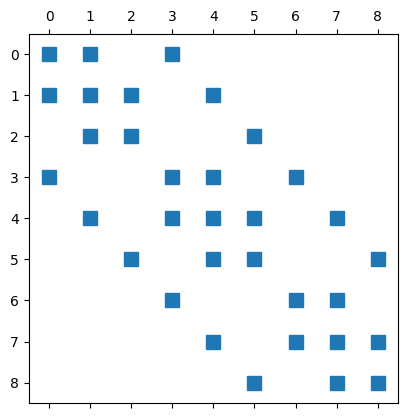

In [68]:
plt.spy(mat.T); plt.show()

In [69]:
vec.W

[array([0.66931877]), array([ 58.5849729 , 109.84682418])]

In [70]:
mat.J.todense()

matrix([[  0.66931877,   0.        ,   0.        ,   0.        ,
           0.        ,   0.        ,   0.        ,   0.        ,
           0.        ],
        [  0.        ,   0.        ,   0.        ,   0.        ,
           0.        ,   0.        ,   0.        ,   0.        ,
           0.        ],
        [  0.        ,   0.        ,   0.        ,   0.        ,
           0.        ,   0.        ,   0.        ,   0.        ,
           0.        ],
        [  0.        ,   0.        ,   0.        ,   0.        ,
           0.        ,   0.        ,   0.        ,   0.        ,
           0.        ],
        [  0.        ,   0.        ,   0.        ,   0.        ,
           0.        ,   0.        ,   0.        ,   0.        ,
           0.        ],
        [  0.        ,   0.        ,   0.        ,   0.        ,
           0.        ,   0.        ,   0.        ,   0.        ,
           0.        ],
        [  0.        ,   0.        ,   0.        ,   0.        ,
           

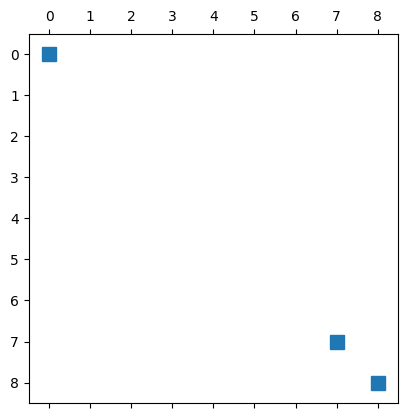

In [71]:
plt.spy(mat.J); plt.show()

In [72]:
mat.Q.todense()

matrix([[  2677.27509522],
        [     0.        ],
        [     0.        ],
        [     0.        ],
        [     0.        ],
        [     0.        ],
        [     0.        ],
        [117169.94579205],
        [219693.64836009]])

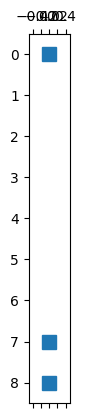

In [73]:
plt.spy(mat.Q); plt.show()

In [74]:
mat.G

array([[-1.24053904e-13],
       [ 0.00000000e+00],
       [ 0.00000000e+00],
       [-2.48107809e-13],
       [ 0.00000000e+00],
       [-6.61620823e-13],
       [ 3.30810411e-13],
       [ 0.00000000e+00],
       [-6.61620823e-13]])

In [85]:
press = np.full(9,3000)*6894.76

for tcurr,tstep in time:
    press = solver.method.implicit(mat,press.reshape((-1,1)))
    print(press/6894.76)

[3092.81155628 2980.20368017 2945.48368508 2930.93064138 2870.06273822
 2825.46728636 2682.10708308 2226.96313333 2153.53514859]
[3121.13116832 2939.20923215 2869.25958579 2836.21544712 2752.15709938
 2689.20402253 2450.89104793 2086.40862243 2042.09517513]
[3112.21999452 2885.83576177 2790.23639643 2742.90885209 2657.12143613
 2590.3594036  2308.5987731  2052.02772213 2024.33281237]
[3083.60861049 2827.65829672 2715.95004612 2660.65779632 2580.35990665
 2515.55533626 2222.51595911 2038.59646478 2019.42915177]
[3046.04528763 2769.64147597 2648.80311534 2591.10838606 2517.38247745
 2456.29820939 2169.38558674 2031.11194414 2016.79211466]


In [86]:
press = np.full(9,3000)*6894.76

for _ in range(1000):
    press = solver.method.implicit(mat,press.reshape((-1,1)))

print(press/6894.76)

[2662.63127696 2303.35428039 2184.63306044 2202.4493765  2153.2196594
 2116.68799302 2034.87343795 2007.45192073 2004.17449866]


6. Post-Processing